In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [97]:
df = pd.read_csv('Hotel Reservations.csv')

In [98]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

No missing data, no duplicates

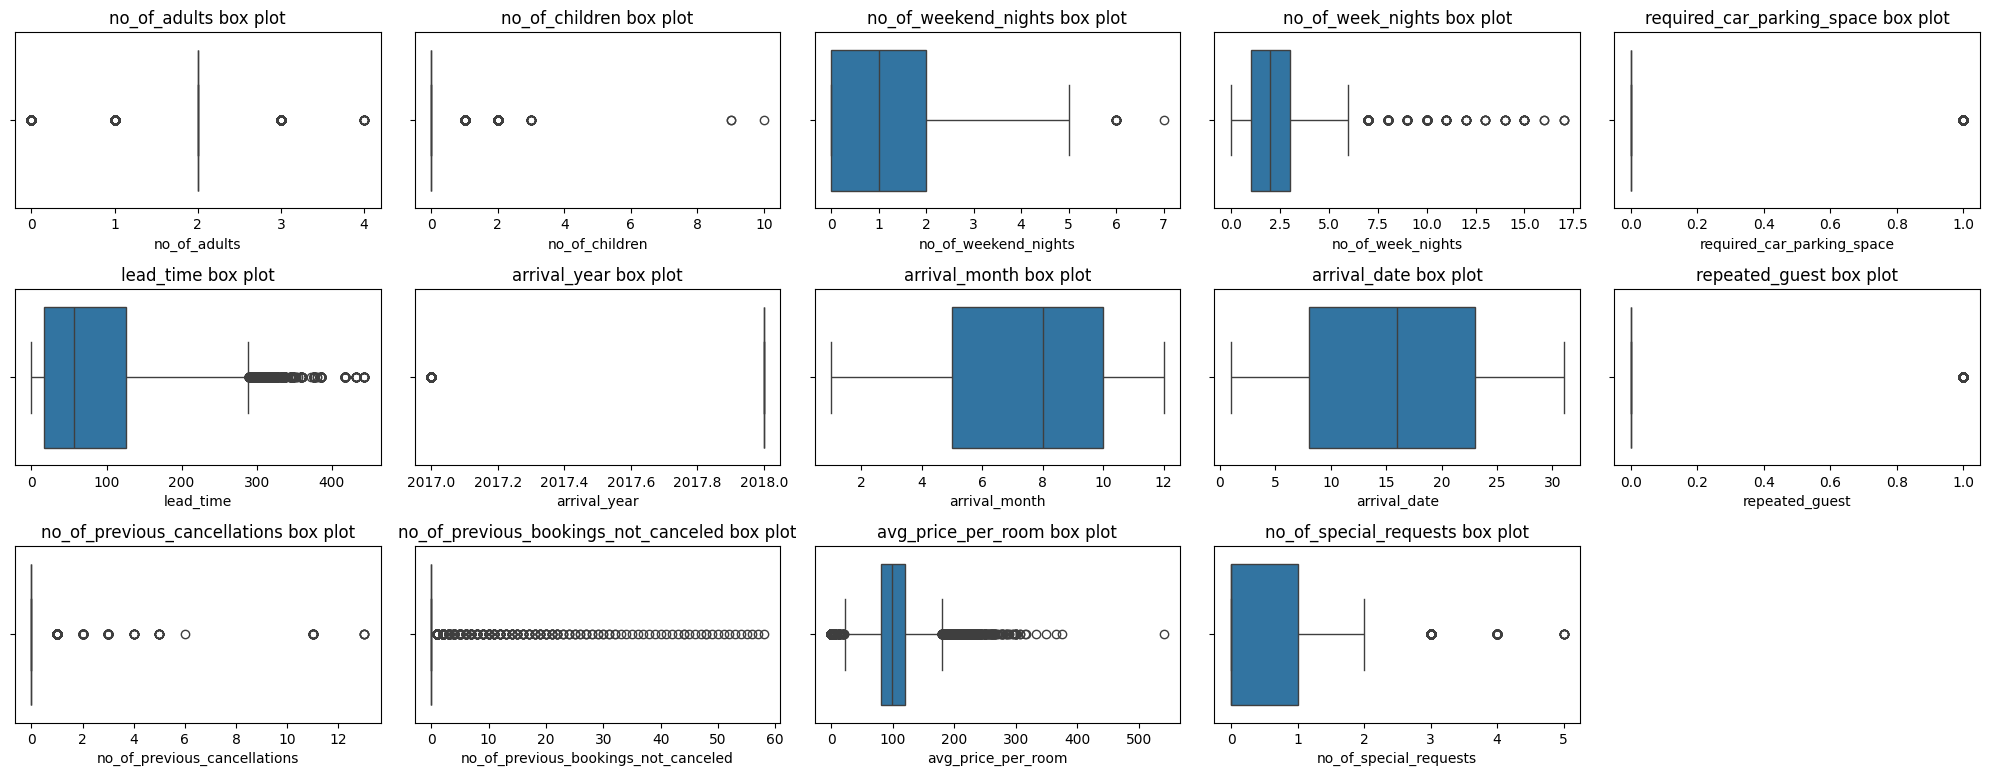

In [100]:
# Select numeric columns for detecting outliers
numeric_df = df.select_dtypes(include = ['number'])

# Use boxplot to visualize outliers for better understanding
plt.figure(figsize = (20, 10))
for index, column in enumerate(numeric_df.columns):
    plt.subplot(4, 5, index + 1)
    sns.boxplot(x = numeric_df[column])
    plt.title(f'{column} box plot')

plt.tight_layout()
plt.show()

Looking at these box plots you can see that although there are some outliers in the data, it is possible that they are special cases, **e.g**. :

there is a room occupied by 8 children, but  considering that it might be a large family with eight children or some school travel plans

some people booking rooms for many nights, possibly long term customers, etc. that

It has some significance and should not be easily deleted.
So for the time being, nothing will be done about it.

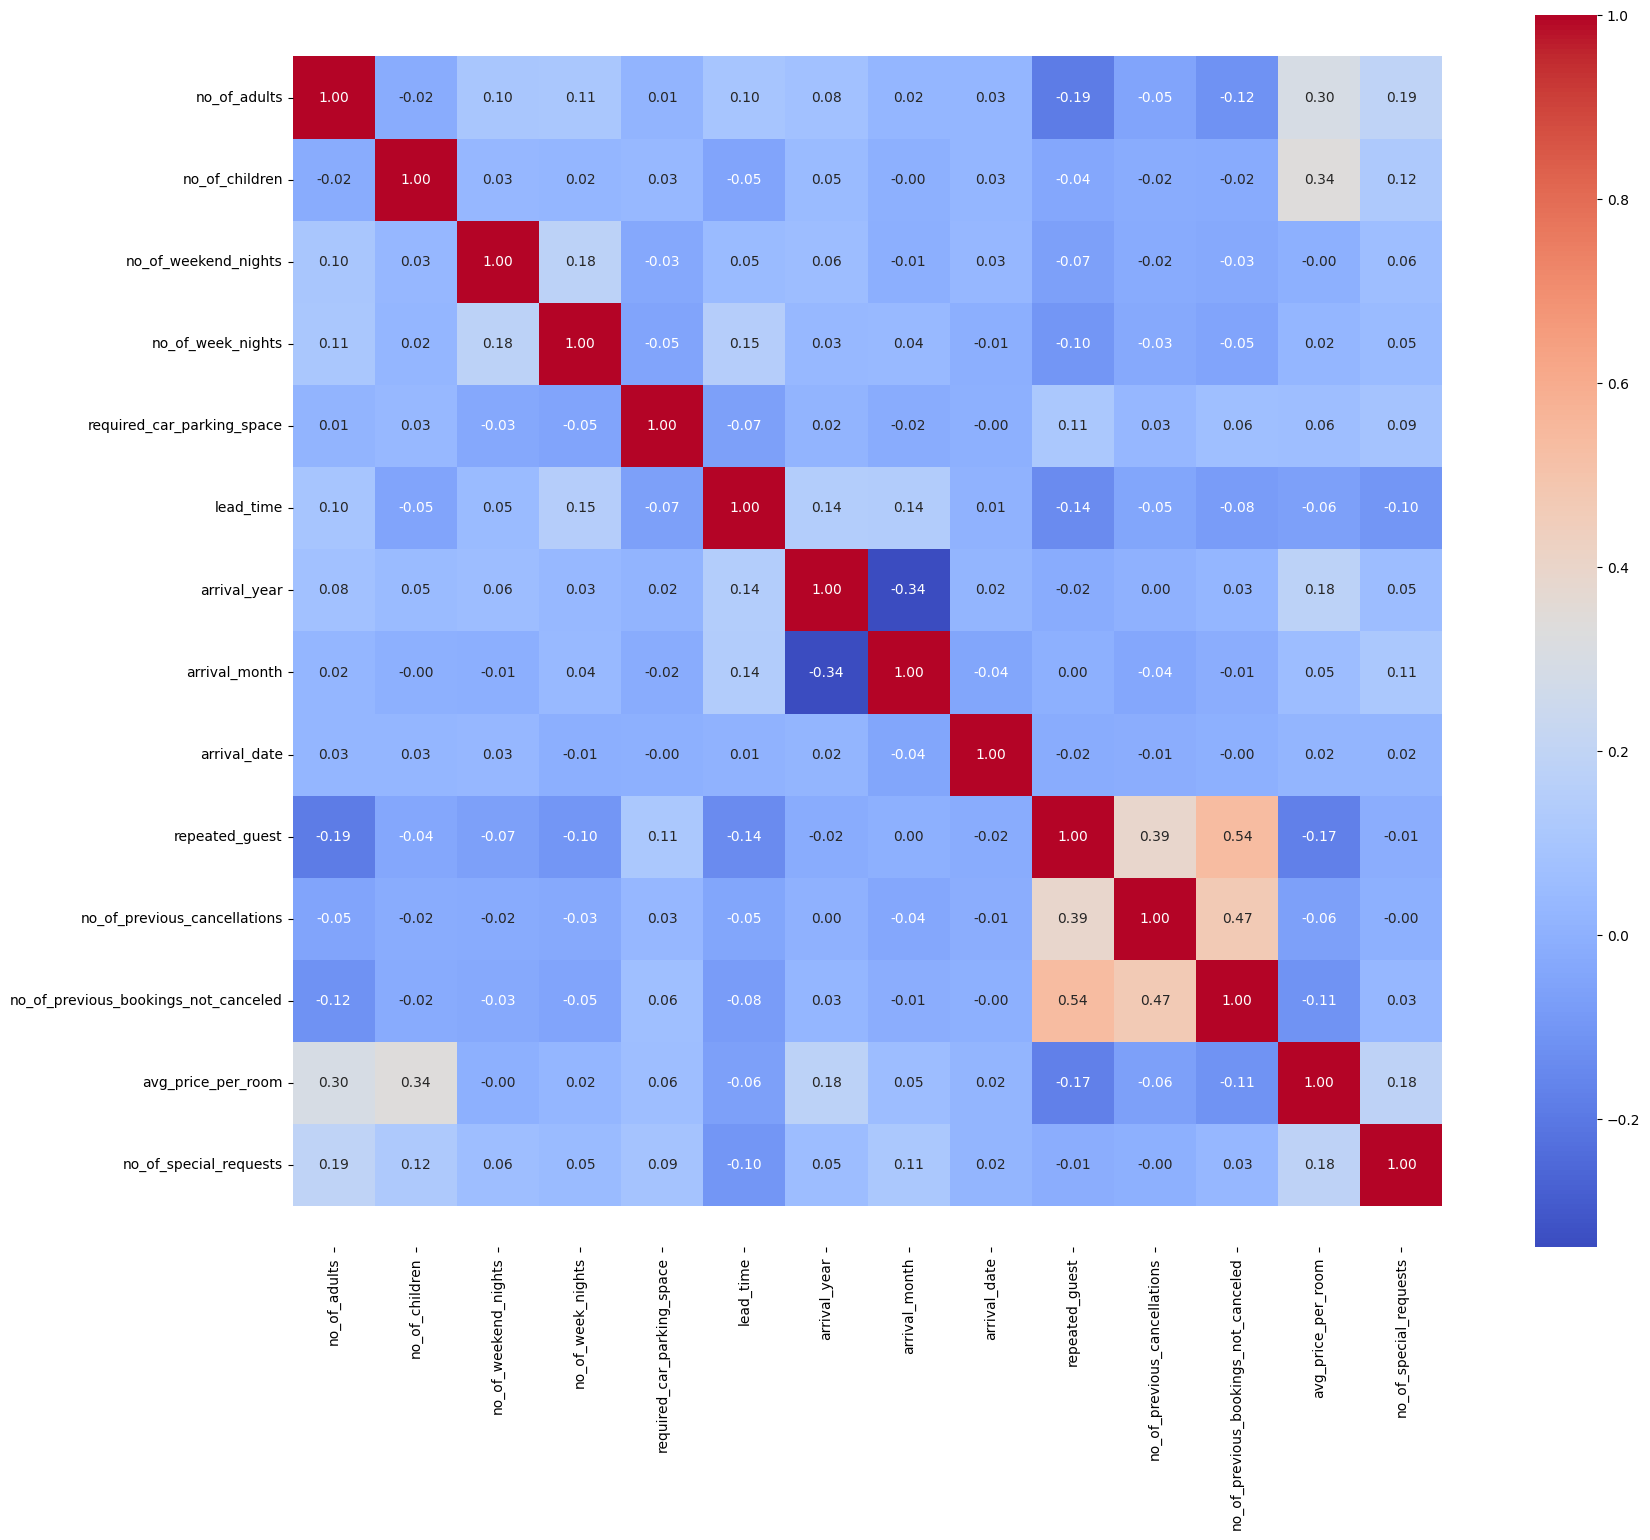

In [101]:
# Select numeric columns for correlation
numeric_df = df.select_dtypes(include = ['number'])

# Create correlation matrix
plt.figure(figsize=(24, 16))
corr_matrix = numeric_df.corr()

ax = sns.heatmap(corr_matrix, square = True, annot = True, fmt = '.2f', cmap = 'coolwarm')

# Rotate x-axis tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

# Adjust the y-axis limits to avoid visual issues
ax.set_ylim(ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5)
plt.show()

Booking related variables such as ‘no_of_previous_bookings_not_canceled “ and ”repeated_guest’ have a strong positive correlation between them, indicating that customers with a history of not cancelling their bookings are more likely to be repeat customers.

There is a significant negative correlation between ‘no_of_previous_cancellations’ and ‘no_of_previous_bookings_not_canceled’, which is consistent with common sense.

In [102]:
# Define the plot_countplot function to reduce redundant code
def plot_countplot(subplot_index, x_col, hue_col, title, data, hue = False) -> None:
    """
    Plot a count plot on a specified subplot in a 4x2 grid layout.

    Parameters:
    subplot_index : int
        The index of the subplot in a grid layout.

    x_col : str
        The column name in the dataframe that will be used for the x-axis.

    hue_col : str
        The column name used for color encoding  when `hue` is True.

    title : str
        The title of the subplot.

    data : pd.DataFrame
        The dataframe containing the data to be plotted.

    hue : bool
        If True, the hue_col will be used to color encode the plot, default is False.

    Returns:
    None
    """
    # Activate subplot
    plt.subplot(4, 2, subplot_index)
    plt.gca().set_title(title)

    if hue:
        sns.countplot(x=x_col, hue=hue_col, edgecolor='black', alpha=0.7, data=data)
    else:
        sns.countplot(x=x_col, edgecolor='black', alpha=0.7, data=data)

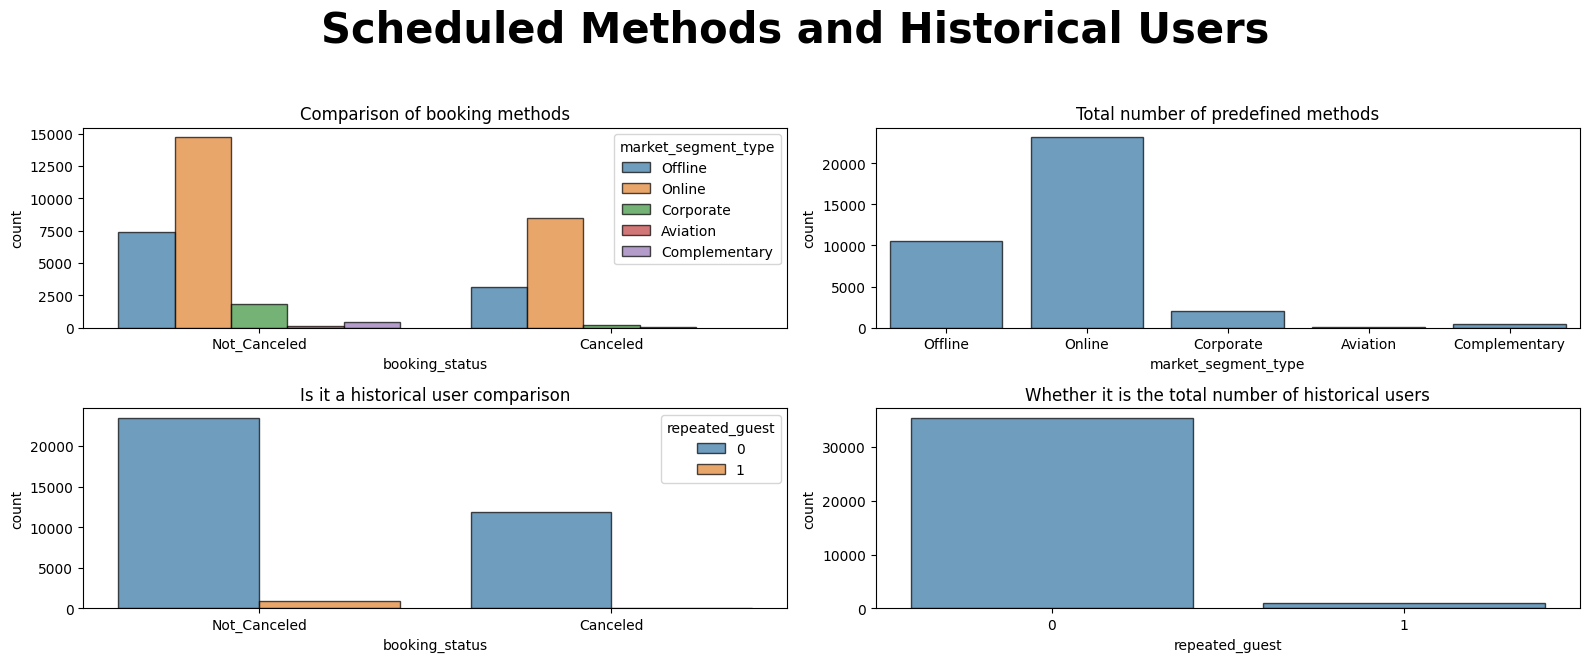

In [103]:
plt.figure(figsize=(16, 12))
plt.suptitle("Scheduled Methods and Historical Users", fontweight = "bold", fontsize = 30)

# Comparison of booking methods
plot_countplot(1, 'booking_status', 'market_segment_type', 'Comparison of booking methods', df, hue = True)

# Total number of predefined methods
plot_countplot(2, 'market_segment_type', None, 'Total number of predefined methods', df)

# Is it a historical user comparison
plot_countplot(3, 'booking_status', 'repeated_guest', 'Is it a historical user comparison', df, hue = True)

# Whether it is the total number of historical users
plot_countplot(4, 'repeated_guest', None, 'Whether it is the total number of historical users', df)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The online channel is dominant and has a higher percentage of non-cancellations

Lower cancellation rates for historical users may represent greater loyalty.

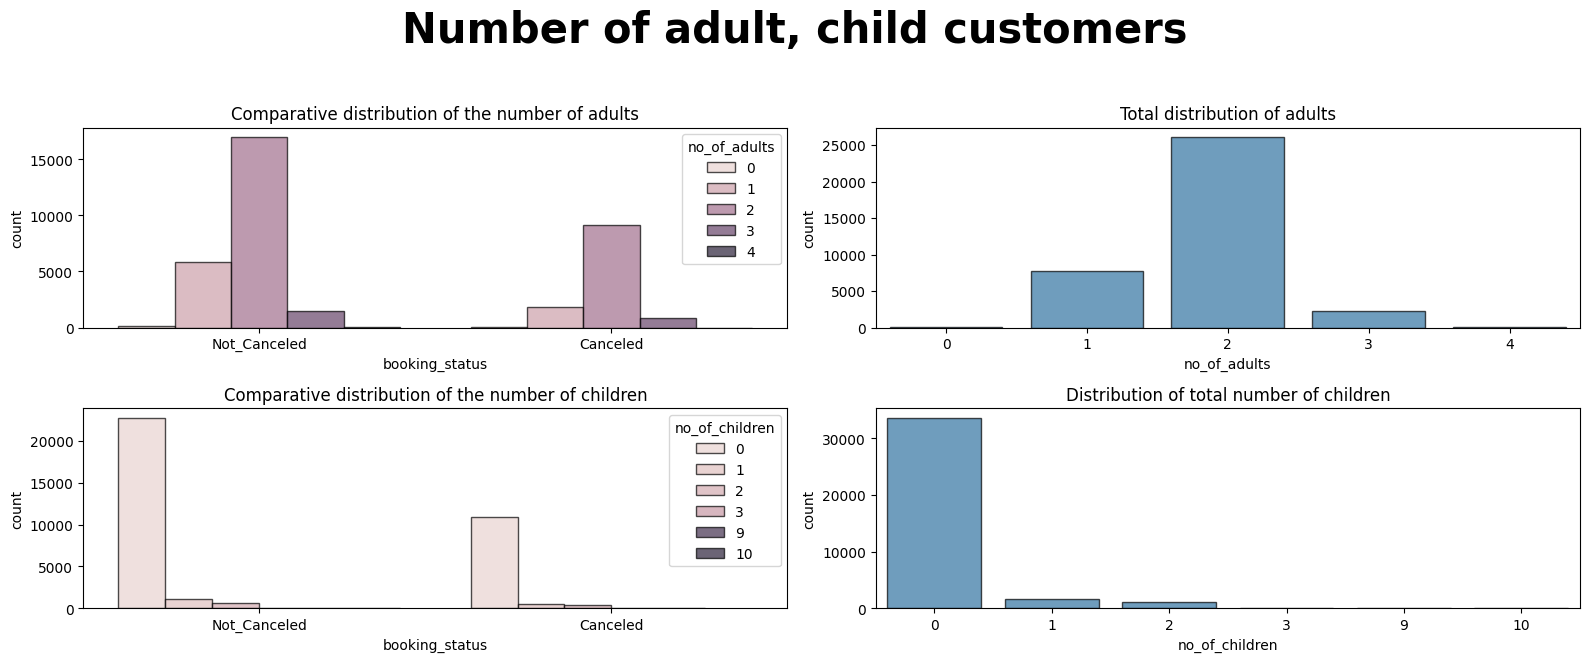

In [104]:
plt.figure(figsize=(16, 12))
plt.suptitle("Number of adult, child customers", fontweight = "bold", fontsize = 30)

# Comparative distribution of the number of adults
plot_countplot(1, 'booking_status', 'no_of_adults', 'Comparative distribution of the number of adults', df, hue = True)

# Total distribution of adults
plot_countplot(2, 'no_of_adults', None, 'Total distribution of adults', df)

# Comparative distribution of the number of children
plot_countplot(3, 'booking_status', 'no_of_children', 'Comparative distribution of the number of children', df, hue = True)

# Distribution of total number of children
plot_countplot(4, 'no_of_children', None, 'Distribution of total number of children', df)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The majority of bookings were for 2 adults, with a relatively small proportion of bookings cancelled, suggesting that double bookings are a common pattern and that this clientele is relatively stable.

The majority of bookings are without children, with fewer families with children, but there are also large specialised families


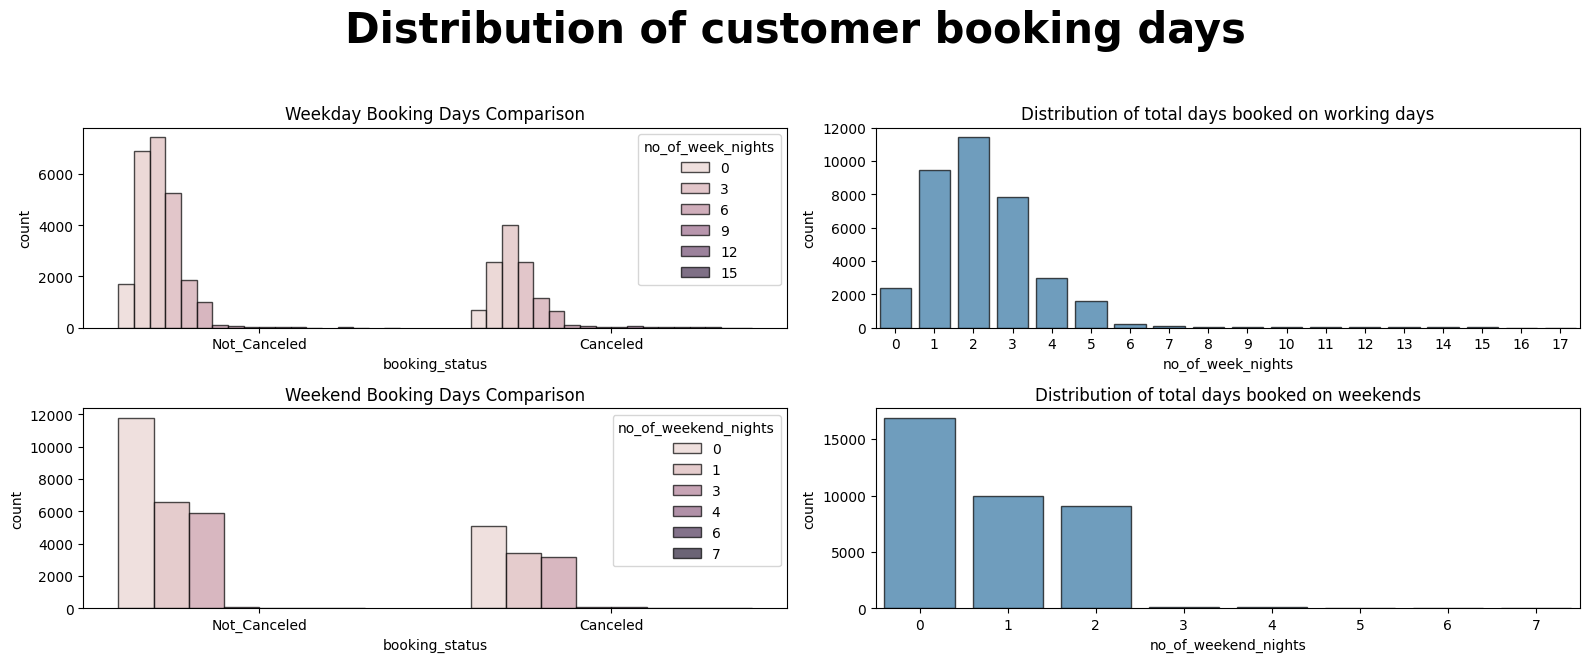

In [105]:
plt.figure(figsize=(16, 12))
plt.suptitle("Distribution of customer booking days", fontweight = "bold", fontsize = 30)

# Comparison of working day bookings
plot_countplot(1, 'booking_status', 'no_of_week_nights', 'Weekday Booking Days Comparison', df, hue = True)

# Distribution of total days booked on working days
plot_countplot(2, 'no_of_week_nights', None, 'Distribution of total days booked on working days', df)

# Comparison of weekend bookings
plot_countplot(3, 'booking_status', 'no_of_weekend_nights', 'Weekend Booking Days Comparison', df, hue = True)

# Distribution of total days booked on weekends
plot_countplot(4, 'no_of_weekend_nights', None, 'Distribution of total days booked on weekends', df)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Weekday occupancy is significantly higher than weekend occupancy, with short-term weekday bookings (1-3 nights) being the most common and non-cancellation rates relatively high.

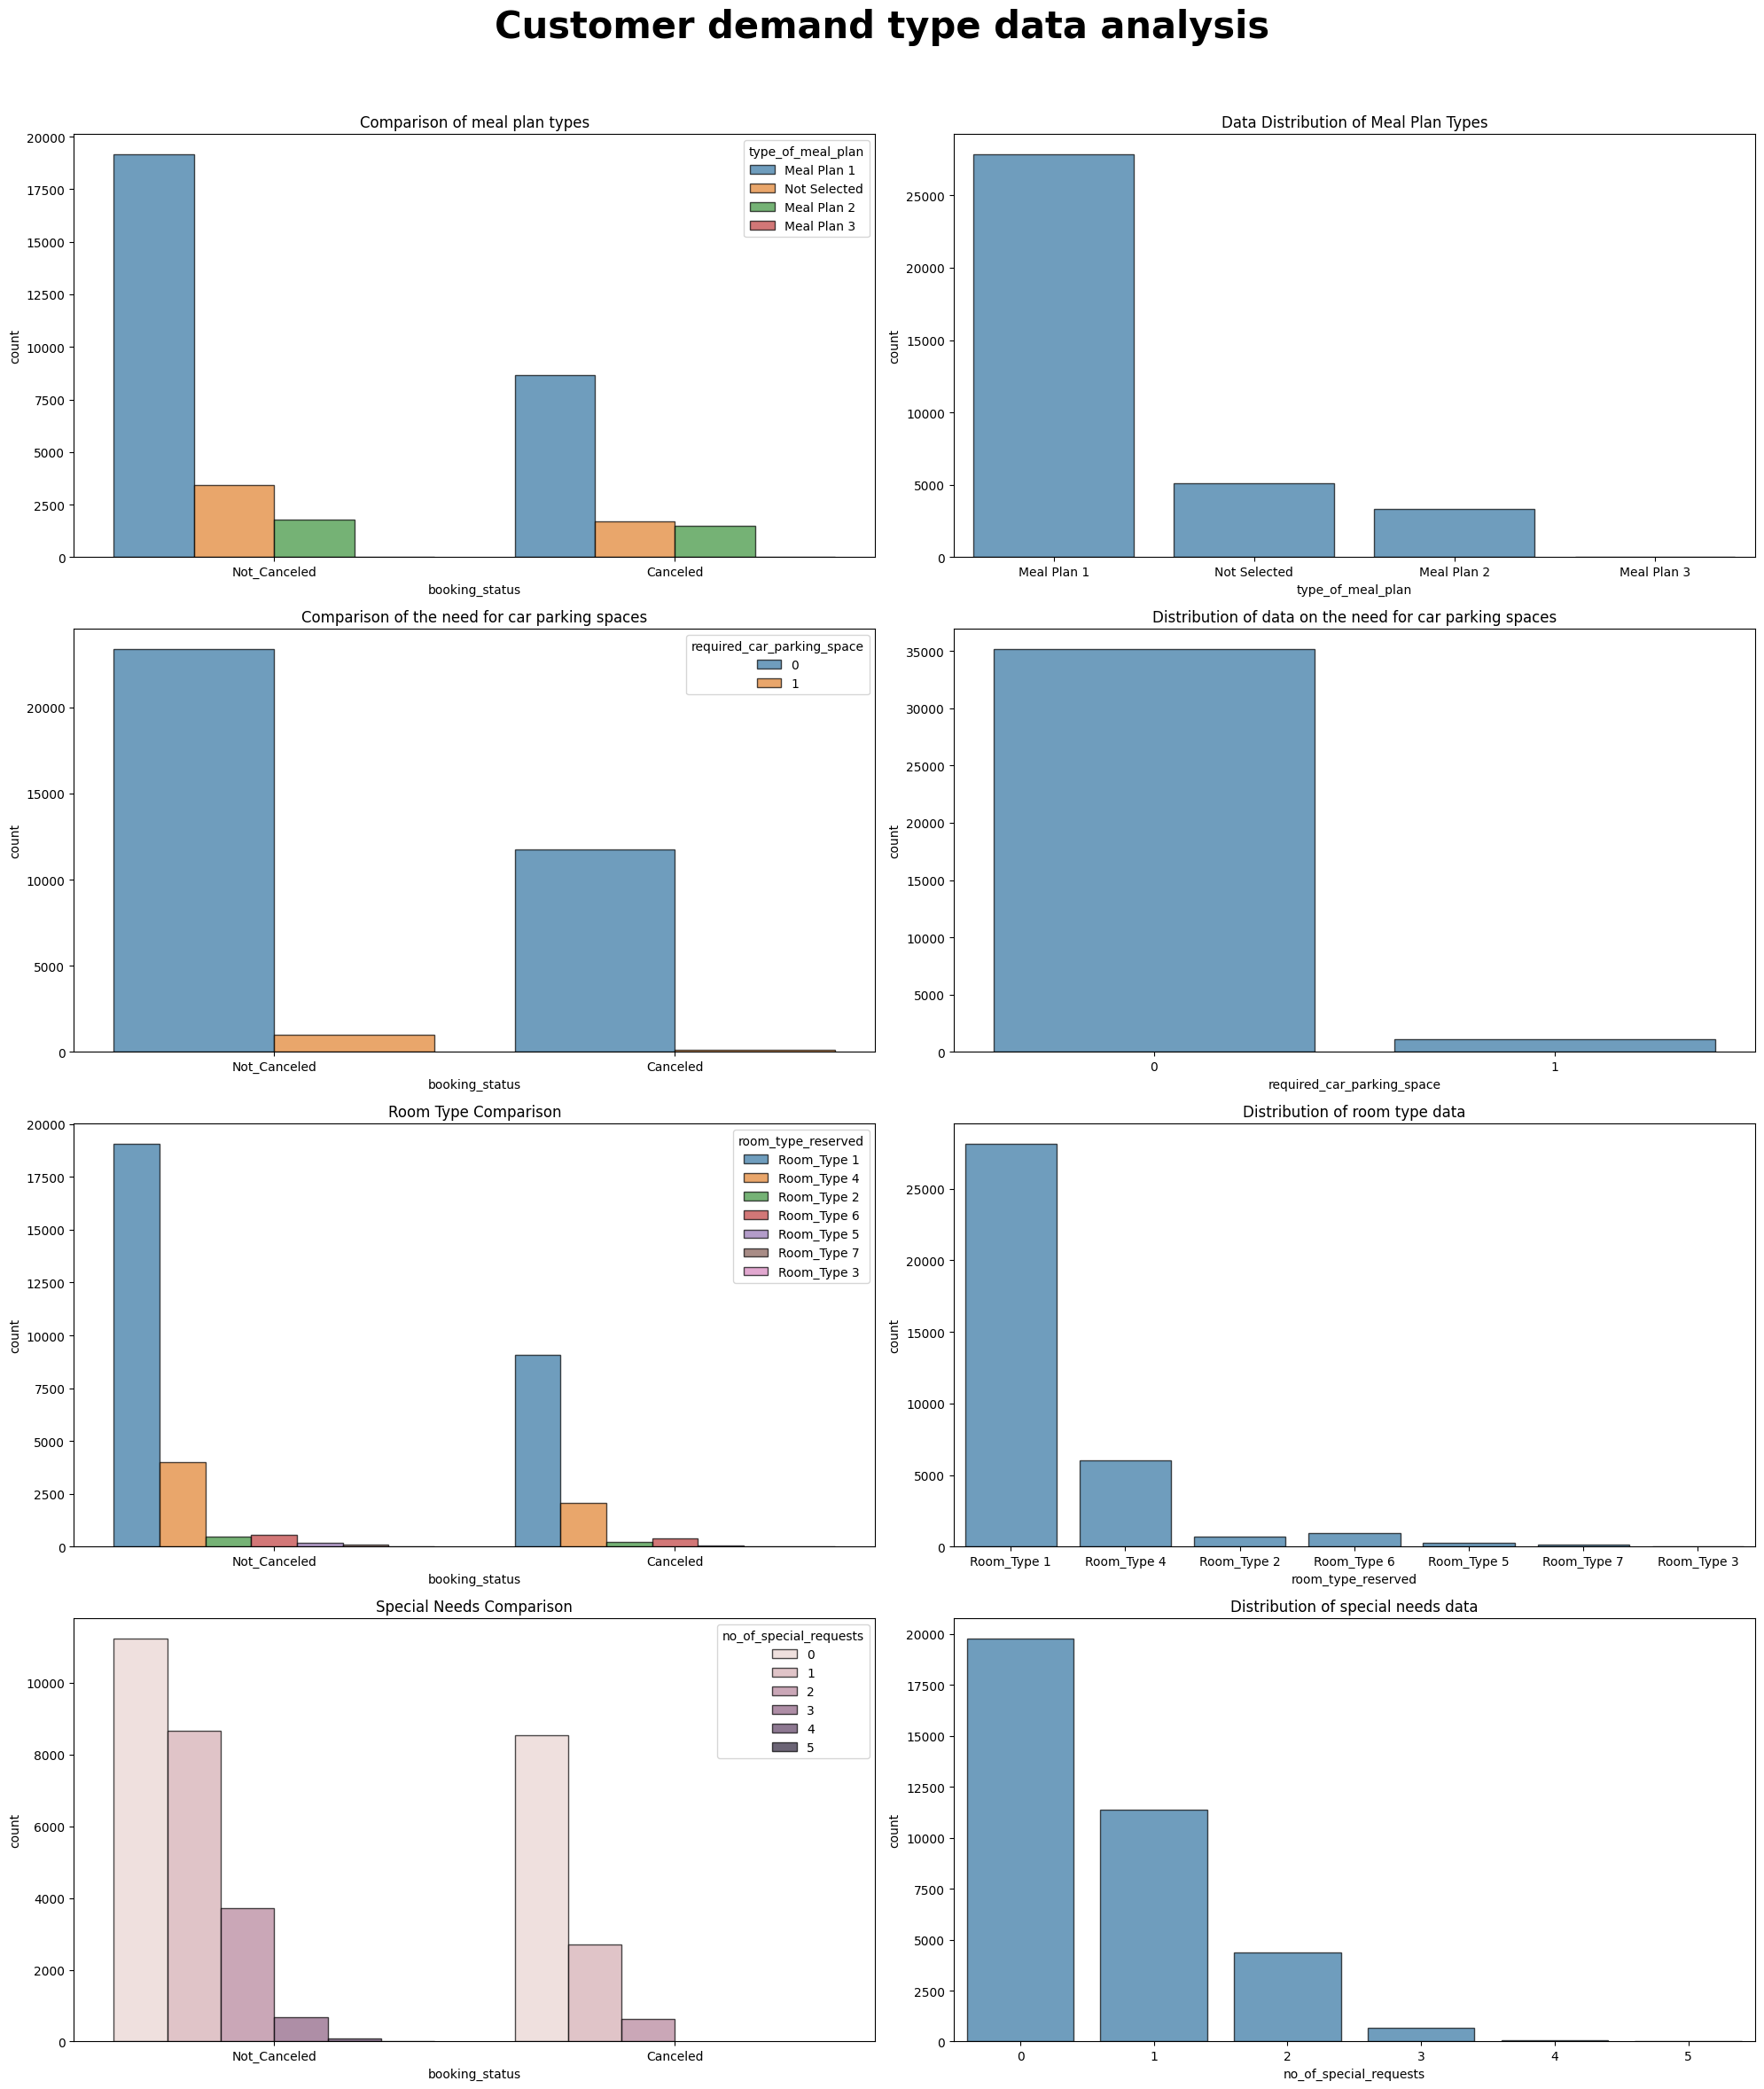

In [106]:
# Customer demand type data analysis
plt.figure(figsize=(20, 24))
plt.suptitle("Customer demand type data analysis", fontweight = "bold", fontsize = 30)

# Comparison of meal plan types
plot_countplot(1, 'booking_status', 'type_of_meal_plan', 'Comparison of meal plan types', df, hue = True)

# Data Distribution of Meal Plan Types
plot_countplot(2, 'type_of_meal_plan', None, 'Data Distribution of Meal Plan Types', df)

# Comparison of the need for car parking spaces
plot_countplot(3, 'booking_status', 'required_car_parking_space', 'Comparison of the need for car parking spaces', df, hue = True)

# Distribution of data on the need for car parking spaces
plot_countplot(4, 'required_car_parking_space', None, 'Distribution of data on the need for car parking spaces', df)

# Room Type Comparison
plot_countplot(5, 'booking_status', 'room_type_reserved', 'Room Type Comparison', df, hue = True)

# Distribution of room type data
plot_countplot(6, 'room_type_reserved', None, 'Distribution of room type data', df)

# Special Needs Comparison
plot_countplot(7, 'booking_status', 'no_of_special_requests', 'Special Needs Comparison', df, hue = True)

# Distribution of special needs data
plot_countplot(8, 'no_of_special_requests', None, 'Distribution of special needs data', df)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The majority of customers have 0 special requests, a few have 1-2 special requests.

The vast majority of customers chose ‘Room Type 1’, with very few choices for other room types.

In most of the non-cancelled bookings, parking was required, while in the cancelled bookings there were relatively few parking requests.

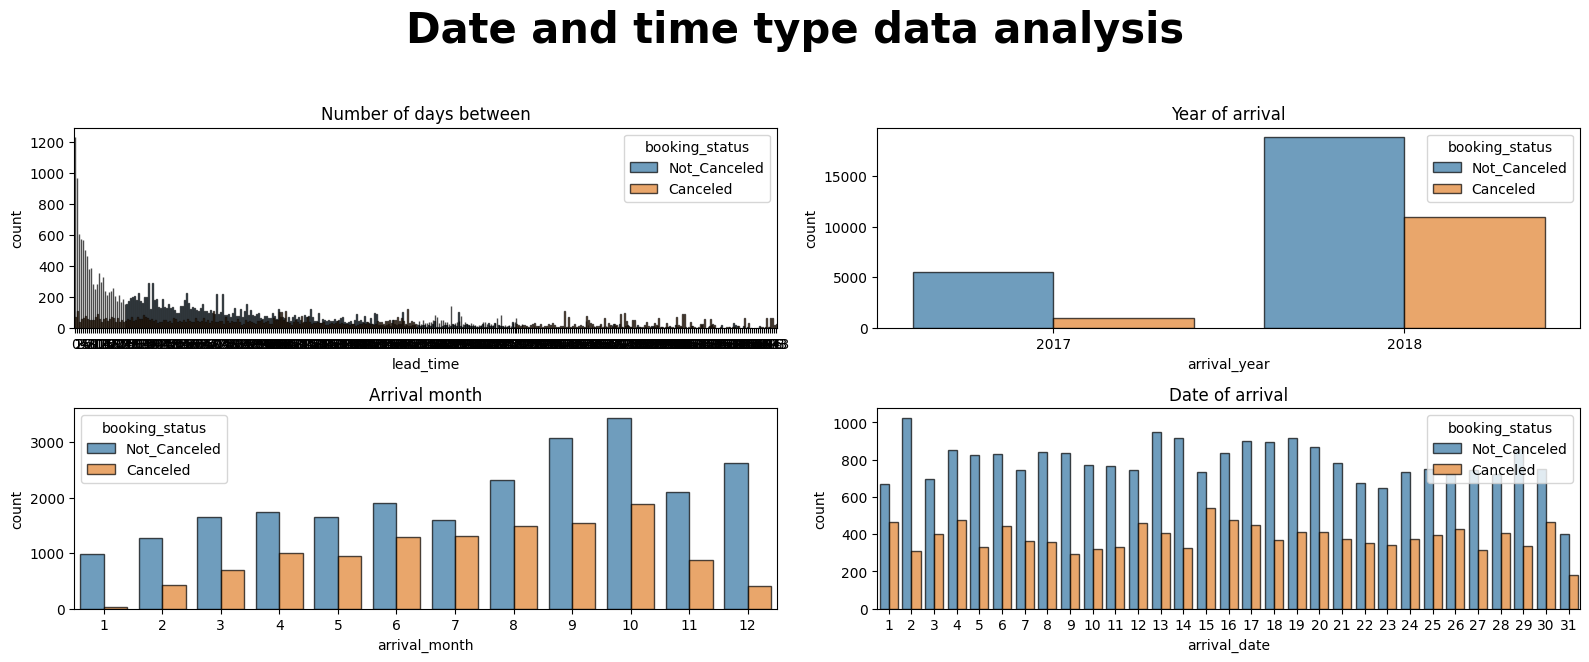

In [107]:
plt.figure(figsize=(16, 12))
plt.suptitle("Date and time type data analysis", fontweight = "bold", fontsize = 30)

# Number of days between
plot_countplot(1, 'lead_time', 'booking_status', 'Number of days between', df,hue = True)
# Year of arrival
plot_countplot(2, 'arrival_year', 'booking_status', 'Year of arrival', df,hue = True)
# Arrival month
plot_countplot(3, 'arrival_month', 'booking_status', 'Arrival month', df,hue = True)
# Date of arrival
plot_countplot(4, 'arrival_date', 'booking_status', 'Date of arrival', df,hue = True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Orders booked farther in advance have a higher likelihood of cancellation.

2018 saw more bookings and cancellations.

The number of bookings peaked during the peak summer season (August and September), along with a slight increase in the percentage of cancellations.

The number of bookings is higher in the middle of each month and the percentage of cancellations is relatively stable.

In [108]:
df = df.drop('Booking_ID', axis = 1)

In [109]:
#Label coding of specified data columns
for feat in ['type_of_meal_plan', 'room_type_reserved','market_segment_type','booking_status']:
    lbl = LabelEncoder()
    lbl.fit(df[feat])
    df[feat] = lbl.transform(df[feat])

In [110]:
X = df.drop('booking_status', axis = 1).values
y = df['booking_status']

In [111]:
#Splitting the dataset
train_data,test_data,train_target,test_target = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [112]:
def evaluate_model(model, train_data, test_data, train_target, test_target,model_name, task = 'regression') -> None:
    """
    Train a regression or classification model and compute various evaluation metrics.

    Parameters:
    model: Regression or classification models
        The model object (regressor or classifier) to be trained and evaluated.

    train_data: ndarray
        The training data features.

    test_data: ndarray
        The test data features.

    train_target: ndarray
        The true labels for the training data.

    test_target: ndarray
        The true labels for the test data.

    model_name: str
        The name of the model for output purposes.

    task: str
        The type of task, either 'regression' or 'classification', default is 'regression'.

    Returns:
    None
    """
    # Train the model
    model.fit(train_data, train_target)

    # Make predictions on the test data
    y_pred = model.predict(test_data)

    if task == 'regression':
        # Compute regression metrics
        rmse = mean_squared_error(test_target, y_pred, squared=False)
        print(f'{model_name} Regression Metrics:')
        print(f'  RMSE: {rmse}')

    elif task == 'classification':
        # Compute classification metrics
        accuracy = accuracy_score(test_target, y_pred)
        print(f'{model_name} Classification Metrics:')
        print(f'  Accuracy: {accuracy}')

    else:
        print(f'Unknown task type: {task}. Please specify "regression" or "classification".')

In [113]:
# regression models
knn_regression = KNeighborsRegressor()
tree_regression = DecisionTreeRegressor()
svr_regression = SVR()
lin_regression = LinearRegression()

# Call the function for regression tasks
evaluate_model(knn_regression, train_data, test_data, train_target, test_target, "KNN")
evaluate_model(tree_regression, train_data, test_data, train_target, test_target, "Decision Tree")
evaluate_model(svr_regression, train_data, test_data, train_target, test_target, "SVR")
evaluate_model(lin_regression, train_data, test_data, train_target, test_target, "Linear Regression")

KNN Regression Metrics:
  RMSE: 0.3703297413424256
Decision Tree Regression Metrics:
  RMSE: 0.35851829284694564
SVR Regression Metrics:
  RMSE: 0.4335573180819427
Linear Regression Regression Metrics:
  RMSE: 0.3876987502231685


In [114]:
# classification models
knn_classification = KNeighborsClassifier()
tree_classification = DecisionTreeClassifier()
svm_classification = SVC()
log_regression = LogisticRegression()

# Call the function for classification tasks
evaluate_model(knn_classification, train_data, test_data, train_target, test_target, "KNN", task='classification')
evaluate_model(tree_classification, train_data, test_data, train_target, test_target, "Decision Tree", task='classification')
evaluate_model(svm_classification, train_data, test_data, train_target, test_target, "SVM", task='classification')
evaluate_model(log_regression, train_data, test_data, train_target, test_target, "Logistic Regression", task='classification')

KNN Classification Metrics:
  Accuracy: 0.8091300033079722
Decision Tree Classification Metrics:
  Accuracy: 0.8664681883338846
SVM Classification Metrics:
  Accuracy: 0.7606130775168155
Logistic Regression Classification Metrics:
  Accuracy: 0.783438085786746


Accuracy Comparison:
The decision tree classifier has the highest accuracy indicating that it has the best classification performance on the test data.
, while the SVM has the lowest accuracy , indicating that the classification performance of SVM is weak.

RMSE Comparison:
Decision tree regression has the lowest RMSE ， indicating that it performs best in continuous value prediction task.
SVR regression had the highest RMSE , indicating that it performed the worst in the regression task.

Conclusion:
In the classification task (based on accuracy), decision tree is the best performing model, followed by KNN，LogisticRegression and SVM performs the worst. In the regression task (based on RMSE), Decision Tree regression also performed the best with the lowest RMSE, SVR regression performed the worst. Taken together, decision tree performs optimally in both tasks based on classification accuracy and regression RMSE.